# Machine Learning Homework 3

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import os
from sklearn import svm
from sklearn.decomposition import PCA
from scipy.stats import multivariate_normal

# you can choose one of the following package for image reading/processing
import cv2
import PIL

## 1. Support Vector Machine (SVM)

In [2]:
###############
## Load Data ##
###############
data_x_df = pd.read_csv("x_train.csv", header=None)
data_t_df = pd.read_csv("t_train.csv", header=None)

## Convert into numpy array
x_array = data_x_df.to_numpy()
t_array = data_t_df.to_numpy()

## Normalization
x_train = cv2.normalize(x_array, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
t_train = t_array

## Sort x & t by t (label)
sort_idx = t_train.argsort(axis=0).flatten()
x_train = x_train[sort_idx]
t_train = t_train[sort_idx]

print("x shape = {}".format(x_array.shape))
print("t shape = {}".format(t_array.shape))

x shape = (300, 784)
t shape = (300, 1)


### 1.1 Principal Component Analysis (PCA)

In [3]:
def myPCA(ori_data, target_dim):
    """
    This function implements Principal Component Analysis (PCA).
    Parameters:
        ori_data (numpy.ndarray): the original data object, dimension = (# samples, # features)
        target_dim (int): number of dimension for the new data object
    Returns:
        new_data (numpy.ndarray): the new data object after dimension reduction, dimension = (# samples, target_dim)
    """
    ## Center data
    x = ori_data - ori_data.mean(axis=0)

    ## Choose principal components by eigenvalues of covariance matrix
    covariance_matrix = np.cov(x.T)
    eigen_values, eigen_vectors = np.linalg.eig(covariance_matrix)
    sort_index = eigen_values.argsort()[::-1] ## get index of (eigenvalues in descending order)
    projection_matrix = eigen_vectors.T[sort_index[:target_dim]].T

    ## Dimension reduction
    new_data = x.dot(projection_matrix)
    new_data = np.real(new_data)

    return new_data

In [4]:
x_pca = myPCA(x_train, target_dim=2)

### 1.2 SVM with Linear / Polynomial Kernel

In [5]:
class SVM:
    """Implementation of Support Vector Machine."""
    def __init__(self, kernel_name="linear", C=1, n_classes=2):
        self.kernel_name = kernel_name ## linear, poly
        self.C = C ## regularization parameter -> trade-off between slack variable penalty & margin
        self.n_classes = n_classes ## For each 1v1 classifier, only 2 classes
        self.sv_x = [] ## x (coordinates on grid) of support vectors, collect for final plot
    
    def feature_transform(self, x):
        """
        Return the feature transform (phi) of x (for kernel).
        Parameter:
            x: input data, should have 2-dimensional shape: (# samples, # features)
        """
        if self.kernel_name == "linear":
            phi = x 
        elif self.kernel_name == "poly":
            x0 = x[:, 0].reshape(x.shape[0], 1) ## first column (feature)
            x1 = x[:, 1].reshape(x.shape[0], 1) ## second column (feature)
            phi = np.hstack((np.square(x0), np.sqrt(2) * x0 * x1, np.square(x1)))
        return phi

    def kernel(self, x, t=None):
        """Return the kernel of x"""
        phi = self.feature_transform(x)
        return phi.dot(phi.T)
    
    def process_label(self, t):
        """Arrange multiclass labels"""
        t_new = np.copy(t)
        t_new[t == list(set(t.flatten().tolist()))[0]] = 1
        t_new[t == list(set(t.flatten().tolist()))[1]] = -1
        return t_new
    
    def get_multiplier(self, x, t):
        """Find Lagrange multipliers / coefficients (a_n) by sklearn.svm"""
        ## Finding multipliers: {dual_coef_: multipliers (alpha * t) of support vectors, support_  : indices of support vectors}
        classifier = svm.SVC(C=self.C, kernel=self.kernel)
        classifier.fit(x, t.flatten())
        coef = np.abs(classifier.dual_coef_) ## shape: (n_classes - 1, n_SV)
        sv_idx = classifier.support_ ## shape: (n_SV,)
        
        multiplier = np.zeros((x.shape[0], self.n_classes - 1))
        multiplier[sv_idx] = coef.T ## 200 * 1
        
        return sv_idx, multiplier
    
    def train(self, x, t):
        """Train three 1v1 classifiers."""
        classifiers = {}
        for ignored_label in range(len(set(t.flatten()))): ## Ignored 3 labels respectively
            x_binary = x[(t != ignored_label).flatten()]
            t_binary = t[(t != ignored_label).flatten()]
            
            t_new = self.process_label(t_binary)
            sv_idx, multiplier = self.get_multiplier(x_binary, t_new)
            
            ## Find weight
            phi = self.feature_transform(x_binary)
            weight = (multiplier * t_new).T.dot(phi)
            
            ## Find bias
            M_idx = np.where((multiplier > 0) & (multiplier < self.C))[0] ## set of indices of data points with 0 < an < C
            bias = np.mean(t_new[M_idx] - (multiplier[sv_idx] * t_new[sv_idx]).T.dot(self.kernel(x_binary[sv_idx])))
            
            ## Store classifier into dictionary
            clf_name = str(list(set(t_binary.flatten().tolist()))[0]) + str(list(set(t_binary.flatten().tolist()))[1])
            classifiers[clf_name] = [weight, bias]
            
            ## Record support vectors
            self.sv_x.extend(x_binary[sv_idx].tolist())
        
        return classifiers
        
    def predict(self, x_pred, classifiers):
        """Predict the class of each sample."""
        preds = []
        for x in x_pred: ## For each sample
            vote = []
            for clf_name, classifier in classifiers.items():
                weight, bias = classifier[0], classifier[1]
                y = weight.dot(self.feature_transform(x.reshape(1, 2)).T) + bias
                if y > 0:
                    vote.append(int(clf_name[0]))
                else:
                    vote.append(int(clf_name[1]))
            preds.append(max(set(vote), key=vote.count))
        preds = np.array([preds]).T
        return preds
    
    def make_meshgrid(self, x, y, h=0.01):
        x_min, x_max = x.min() - 0.3, x.max() + 0.3
        y_min, y_max = y.min() - 0.3, y.max() + 0.3
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        return xx, yy
    
    def plot_decision_boundary(self, grid_x, grid_y, grid_preds, x, t, classifiers):
        ## Plot the prediction of whole grid
        cmap = ListedColormap(["red","green","blue"], name='from_list', N=None)
        plt.contourf(grid_x, grid_y, grid_preds, cmap=cmap, alpha=0.3)
        
        ## Plot the ground truth labels
        colors = ["r", "g", "b"]
        for color_idx, color in enumerate(colors):
            x_ = x[(t == color_idx).flatten()]
            plt.scatter(x_[:, 0], x_[:, 1], c=color, marker="x", label="Chinese {}".format(color_idx))
        
        ## Plot support vector
        sv_set = set(tuple(point) for point in self.sv_x)
        sv_arr = np.array(list(sv_set))
        plt.scatter(sv_arr[:, 0], sv_arr[:, 1], facecolors="none", edgecolors="k", label="support vector")
        
        plt.legend()
        plt.title("{} SVM".format(self.kernel_name))
        plt.savefig("./result/{}_SVM.png".format(self.kernel_name), dpi=300)
        plt.show()

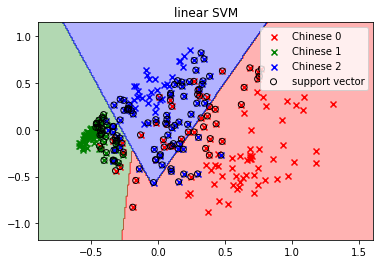

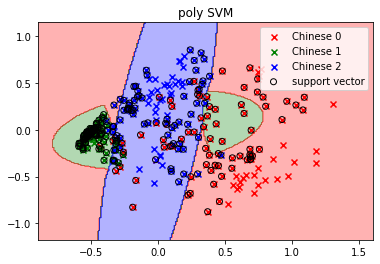

In [7]:
kernels = ["linear", "poly"]
for kernel in kernels:
    model = SVM(kernel_name=kernel, C=1.8)
    classifiers = model.train(x_pca, t_train)
    #preds = model.predict(x_pca, classifiers)
    
    ## Predict the whole grid
    grid_x, grid_y = model.make_meshgrid(x_pca[:, 0], x_pca[:, 1])
    coordinates = np.hstack((np.expand_dims(grid_x.flatten(), axis=1), np.expand_dims(grid_y.flatten(), axis=1)))
    grid_preds = model.predict(coordinates, classifiers)
    
    ## Plot
    model.plot_decision_boundary(grid_x, grid_y, grid_preds.reshape(grid_x.shape), x_pca, t_train, classifiers)

## 2. Gaussian Mixture Model

In [2]:
###############
## Load data ##
###############
img_arr  = cv2.imread("hw3.jpg")
#img_norm = cv2.normalize(img_arr, None, 0, 1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_64F)
img_norm = img_arr / 255
print("hw3.jpg shape: {}".format(img_norm.shape))

x_train = img_norm.reshape(img_norm.shape[0] * img_norm.shape[1], img_norm.shape[2])
print("\nReshape into data points with 3 features (RGB)")
print("x_train shape: {}".format(x_train.shape))

hw3.jpg shape: (410, 615, 3)

Reshape into data points with 3 features (RGB)
x_train shape: (252150, 3)


### 2.1 K-means

In [6]:
class Kmeans:
    """Implementation of K-means clustering"""
    def  __init__(self, k):
        self.k = k ## number of centroids
    
    def init_centroids(self, x):
        """
        Randomly choose k samples as centroids.
        Parameters:
            x  : input data
        Returns:
            rnk: indicator of each of the k clusters
            u  : k centroids (means), shape: (self.k, 3)
        """
        rnk = np.zeros((x.shape[0], self.k))
        rand_k_idx = np.random.randint(0, x.shape[0], size=self.k)
        u = x[rand_k_idx]
        return rnk, u
        
    def cluster(self, x_train):
        """Clustering process"""
        print("K-means, K = {}, clustering...".format(self.k))
        pre_rnk, u = self.init_centroids(x_train)
        
        for iter_ in range(100000):
            print("Iteration: {}".format(iter_), end="\r")
            ## 1. Calculate distance of all points from each centroids
            dist = np.sum(np.square((x_train[:, None] - u)), axis=2)
            min_idx = np.argmin(dist, axis=1)
            
            ## 2. Update clusters
            new_rnk = np.zeros((x_train.shape[0], self.k))
            for idx in range(min_idx.shape[0]):
                new_rnk[idx][min_idx[idx]] = 1
            
            ## 3. Check converge or not
            if np.array_equal(pre_rnk, new_rnk):
                print("\nTerminate at iteration {}".format(iter_))
                break
            else:
                pre_rnk = new_rnk
            
            ## 4. Update centroids, need to have shape: (self.k, 3)
            u = np.array([rk.dot(x_train) / np.sum(rk, axis=0) for rk in new_rnk.T])
        
        return new_rnk, u
    
    def display_k_centroids(self, centroids):
        """Print the k centroids."""
        print(" K\t  R\t  G\t  B")
        for k, centroid in enumerate(centroids):
            centroid = (centroid * 255).astype(int)
            print("{:2d}\t{:3d}\t{:3d}\t{:3d}".format(k, centroid[0], centroid[1], centroid[2]))

In [8]:
def show_cluster_img(img_ori, rnk, centroids, model="Kmeans"):
    """Display & save the image with k clusters"""
    cluster_idx = np.argmax(rnk, axis=1)
    points = centroids[cluster_idx]
    img_new = (points.reshape(img_ori.shape) * 255).astype(int)
    
    cv2.imwrite("./result/{}_K_{}.png".format(model, rnk.shape[1]), img_new)
    
    plt.imshow(img_new)
    plt.title("K = {}".format(rnk.shape[1]))
    plt.show()

K-means, K = 3, clustering...
Iteration: 27
Terminate at iteration 27
 K	  R	  G	  B
 0	189	186	177
 1	 77	118	106
 2	 18	 31	 35


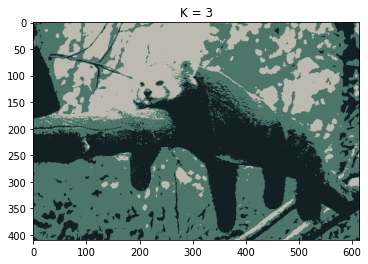

K-means, K = 7, clustering...
Iteration: 152
Terminate at iteration 152
 K	  R	  G	  B
 0	 51	 99	 82
 1	 81	124	112
 2	176	174	163
 3	 31	 52	 59
 4	122	145	138
 5	226	217	208
 6	  9	 14	 18


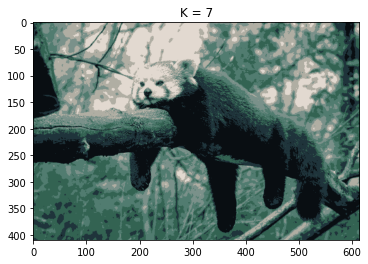

K-means, K = 10, clustering...
Iteration: 81
Terminate at iteration 81
 K	  R	  G	  B
 0	105	138	125
 1	  8	 12	 17
 2	 36	105	 72
 3	 27	 44	 52
 4	 73	105	164
 5	192	185	174
 6	231	221	213
 7	149	157	147
 8	 72	120	100
 9	 56	 76	 84


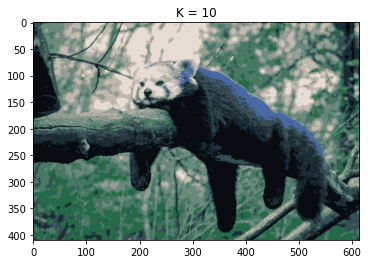

K-means, K = 30, clustering...
Iteration: 401
Terminate at iteration 401
 K	  R	  G	  B
 0	168	165	149
 1	144	147	131
 2	210	198	185
 3	 12	 28	 61
 4	 10	 16	 22
 5	 81	102	 95
 6	166	179	196
 7	 43	 91	 70
 8	 30	 48	 92
 9	 36	 45	 48
10	 73	127	104
11	225	215	207
12	 21	 30	 33
13	140	158	157
14	118	134	127
15	105	157	139
16	  4	  6	  8
17	102	138	189
18	 70	102	162
19	 85	142	121
20	243	234	226
21	101	117	110
22	 52	135	 97
23	190	181	164
24	 47	 71	125
25	 52	112	 84
26	 23	108	 68
27	 66	 85	 81
28	 18	 74	 49
29	 51	 63	 65


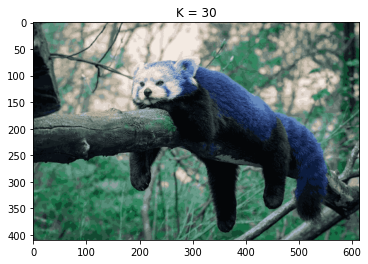

In [9]:
Ks = [3, 7, 10, 30]
rnks, means = [], []
for k in Ks:
    model = Kmeans(k=k)
    rnk, centroids = model.cluster(x_train)
    model.display_k_centroids(centroids)
    show_cluster_img(img_norm, rnk, centroids, model="Kmeans")
    
    rnks.append(rnk)
    means.append(centroids)

### 2.2 GMM

In [10]:
class GMM:
    """Implementation of Gaussian Mixture Model"""
    def __init__(self, rnk, centroids, x_train):
        """
        Initialize mixture weights, means and covariance matrix 
        according to centroids and clusters from Kmeans model.
        """
        self.k = rnk.shape[1]
        self.iters = 100 ## terminate EM algorithm when iteration arrives at 100
        
        ## Mixture weights
        self.PIs = np.sum(rnk, axis=0) / rnk.shape[0]
        
        ## Means & covariance matrix
        self.means = centroids
        self.covs  = np.array([np.cov(x_train[np.where(rk == 1)[0]].T) for rk in rnk.T]) ## shape: (self.k, 3, 3)
        
        ## All Gaussians
        self.Gaussians = np.array([self.PIs[k] * multivariate_normal.pdf(x_train, mean=self.means[k], cov=self.covs[k]) for k in range(self.k)])
        
    def em_optimization(self, rnk, centroids, x_train):
        """Optimize the model through EM algorithm."""
        print("Gaussian Mixture Model, K = {}".format(self.k))
        print("Optimizing through EM algorithm...")
        
        log_likelihoods = []
        for iter_ in range(self.iters):
            print("Iteration {}".format(iter_), end="\r")
            ## E-step
            gammas = self.Gaussians / np.sum(self.Gaussians, axis=0)
            
            ## M-step
            Nk, N = np.sum(gammas, axis=1), x_train.shape[0]
            self.PIs = Nk / N
            self.means = (gammas.dot(x_train).T / Nk).T
            for k in range(self.k):
                self.covs[k] = (gammas[k, :, None] * (x_train - self.means[k])).T.dot((x_train - self.means[k])) / Nk[k]
            
            ## Update all Gaussians
            for k in range(self.k):
                self.Gaussians[k] = self.PIs[k] * multivariate_normal.pdf(x_train, mean=self.means[k], cov=self.covs[k])
            
            ## Calculate log likelihood
            log_likelihood = np.sum(np.log(np.sum(self.Gaussians, axis=0)))
            log_likelihoods.append(log_likelihood)
        
        return log_likelihoods
    
    def plot_curve(self, log_likelihoods):
        """Plot learning curve for log likelihood"""
        plt.plot(range(self.iters), log_likelihoods)
        plt.title("GMM Log Likelihood, K = {}".format(self.k))
        
        plt.savefig("./result/LL_K_{}.png".format(self.k), dpi=300)
        plt.show()

Gaussian Mixture Model, K = 3
Optimizing through EM algorithm...


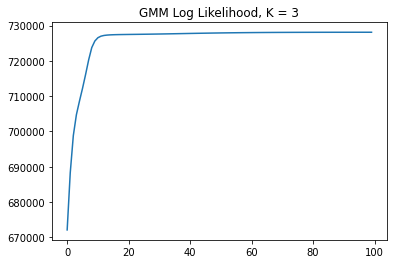

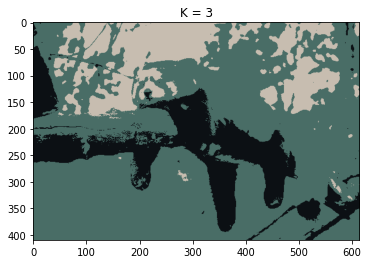

Gaussian Mixture Model, K = 7
Optimizing through EM algorithm...


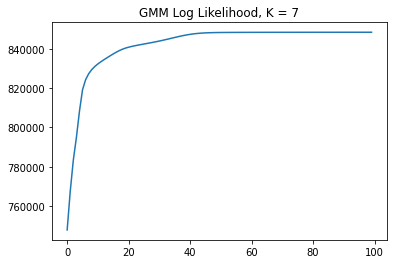

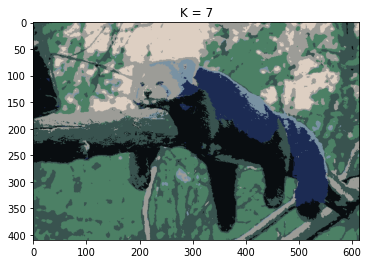

Gaussian Mixture Model, K = 10
Optimizing through EM algorithm...


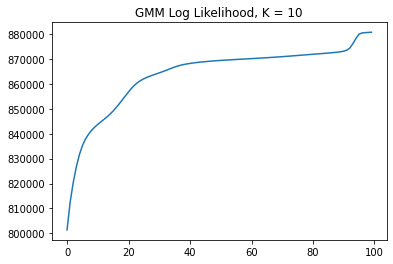

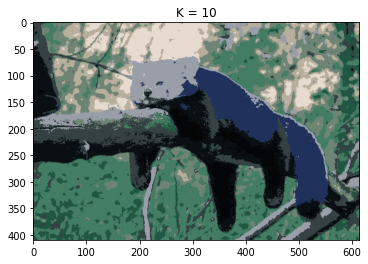

Gaussian Mixture Model, K = 30
Optimizing through EM algorithm...


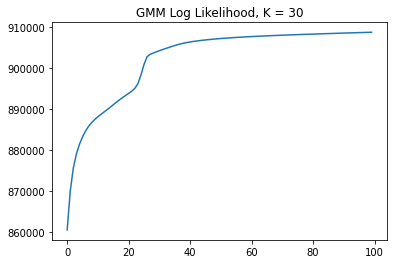

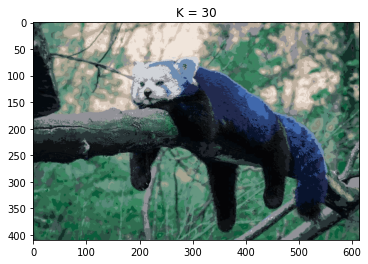

In [11]:
for idx in range(len(Ks)):
    ## Get rnk & means from K-means
    rnk, centroids = rnks[idx], means[idx]
    
    ## Gaussian Mixture Model
    model = GMM(rnk, centroids, x_train)
    log_likelihoods = model.em_optimization(rnk, centroids, x_train)
    model.plot_curve(log_likelihoods)
    show_cluster_img(img_norm, model.Gaussians.T, model.means, model="GMM")